<h1>05 Logistic Regression</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from seaborn import lmplot, stripplot, scatterplot, heatmap

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix

<h1>Introductory Remarks</h1>
<ul>
    <li>We're going to predict whether someone if over the drink-drive limit or not.</li>
    <li>This is classification, not regression.</li>
    <li>We have a dataset collected by some friends of mine. TBH it is too small to do anything reliable.</li>
    <li>We use logistic regression, not linear regression, and we measure accuracy, not mean absolute error.</li>
</ul>

<p>
    <strong>This notebook is incomplete. Your job is to complete it.</strong>
</p>

<h1>Read in and Check the Data</h1>

In [3]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("../datasets/dataset_alcohol.csv")

# Shuffle the dataset
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [4]:
df.shape

(76, 9)

In [5]:
df.columns

Index(['age_yrs', 'height_cm', 'weight_kg', 'duration_mins', 'elapsed_mins',
       'sex', 'last_meal', 'units', 'over_limit'],
      dtype='object')

In [6]:
features = ['age_yrs', 'height_cm', 'weight_kg', 'duration_mins', 'elapsed_mins', 'sex', 'last_meal', 'units', 'gender_constant']

In [7]:
numeric_features = ['age_yrs', 'height_cm', 'weight_kg', 'duration_mins', 'elapsed_mins', 'units', 'gender_constant']

In [8]:
nominal_features = ['sex', 'last_meal']

<p>
    It's your job now to inspect the data. Determine whether there is any cleaning needed.
</p>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age_yrs        76 non-null     int64  
 1   height_cm      76 non-null     int64  
 2   weight_kg      76 non-null     int64  
 3   duration_mins  76 non-null     object 
 4   elapsed_mins   76 non-null     object 
 5   sex            76 non-null     object 
 6   last_meal      76 non-null     object 
 7   units          76 non-null     float64
 8   over_limit     76 non-null     object 
dtypes: float64(1), int64(3), object(5)
memory usage: 5.5+ KB


In [10]:
for feature in nominal_features:
    print(feature, df[feature].unique())

sex ['Male' 'Female']
last_meal ['Snack' 'Lunch' 'Full' 'None' '?']


In [11]:
for col in df:
    df = df[~df[col].astype(str).str.contains('\?')]
    if (df[col].dtype == object):
        try:
            df[col] = df[col].astype(float)
        except ValueError as e:
            print("Column '{}' cannot be converted to float. Skipping!".format(col))
df

Column 'sex' cannot be converted to float. Skipping!
Column 'last_meal' cannot be converted to float. Skipping!
Column 'over_limit' cannot be converted to float. Skipping!


,age_yrs,height_cm,weight_kg,duration_mins,elapsed_mins,sex,last_meal,units,over_limit
0,21,185,85,315.0,10.0,Male,Snack,19.7,Yes
1,34,187,95,240.0,5.0,Male,Lunch,10.2,No
2,23,200,101,60.0,10.0,Male,Snack,4.8,No
3,26,177,76,60.0,10.0,Male,Full,2.9,No
4,19,175,69,30.0,10.0,Male,Full,2.6,No
...,...,...,...,...,...,...,...,...,...
71,20,170,63,270.0,10.0,Female,Lunch,5.9,No
72,28,185,88,120.0,10.0,Male,Full,5.2,No
73,22,177,82,300.0,10.0,Male,Snack,15.0,Yes
74,21,177,88,90.0,10.0,Male,Full,5.2,No


In [12]:
df.describe(include="all")

,age_yrs,height_cm,weight_kg,duration_mins,elapsed_mins,sex,last_meal,units,over_limit
count,73.000000,73.000000,73.000000,73.000000,73.000000,73,73,73.000000,73
unique,NaN,NaN,NaN,NaN,NaN,2,4,NaN,2
top,NaN,NaN,NaN,NaN,NaN,Male,Full,NaN,No
freq,NaN,NaN,NaN,NaN,NaN,58,32,NaN,43
mean,22.479452,176.821918,71.712329,157.397260,16.369863,NaN,NaN,8.926027,NaN
std,5.336222,8.554308,11.558402,100.588924,25.539461,NaN,NaN,5.687926,NaN
min,18.000000,157.000000,47.000000,5.000000,5.000000,NaN,NaN,1.200000,NaN
25%,19.000000,172.000000,63.000000,90.000000,10.000000,NaN,NaN,4.800000,NaN
50%,21.000000,177.000000,72.000000,120.000000,10.000000,NaN,NaN,9.100000,NaN
75%,23.000000,182.000000,79.000000,240.000000,10.000000,NaN,NaN,12.400000,NaN


In [13]:
gender_constant = []
for value in df["sex"]:
    if value == "Female":
        gender_constant.append(0.55)
    else:
        gender_constant.append(0.68)
df["gender_constant"] = gender_constant
df

,age_yrs,height_cm,weight_kg,duration_mins,elapsed_mins,sex,last_meal,units,over_limit,gender_constant
0,21,185,85,315.0,10.0,Male,Snack,19.7,Yes,0.68
1,34,187,95,240.0,5.0,Male,Lunch,10.2,No,0.68
2,23,200,101,60.0,10.0,Male,Snack,4.8,No,0.68
3,26,177,76,60.0,10.0,Male,Full,2.9,No,0.68
4,19,175,69,30.0,10.0,Male,Full,2.6,No,0.68
...,...,...,...,...,...,...,...,...,...,...
71,20,170,63,270.0,10.0,Female,Lunch,5.9,No,0.55
72,28,185,88,120.0,10.0,Male,Full,5.2,No,0.68
73,22,177,82,300.0,10.0,Male,Snack,15.0,Yes,0.68
74,21,177,88,90.0,10.0,Male,Full,5.2,No,0.68


<h1>Create a Test Set</h1>

In [14]:
# Split off the test set: 20% of the dataset.
dev_df, test_df = train_test_split(df, train_size=0.8, stratify=df["over_limit"], random_state=2)

In [15]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(df["over_limit"])
dev_y = label_encoder.transform(dev_df["over_limit"])
test_y = label_encoder.transform(test_df["over_limit"])

<h1>Dataset Exploration</h1>

In [16]:
# It can be good to do this on a copy of the dataset (excluding the test set, of course)
copy_df = dev_df.copy()

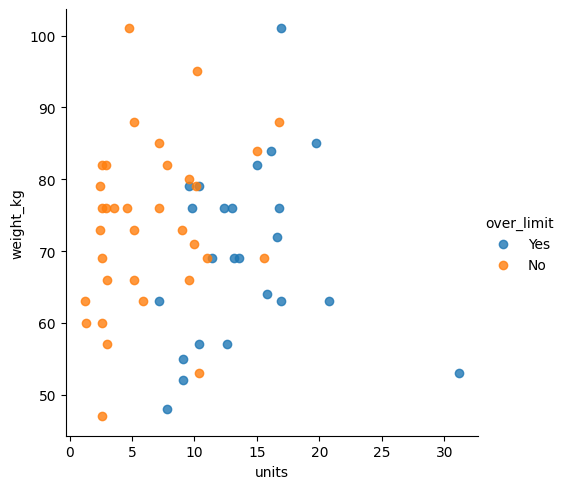

In [17]:
plot = lmplot(x="units", y="weight_kg", hue="over_limit", data=copy_df, fit_reg=False) 

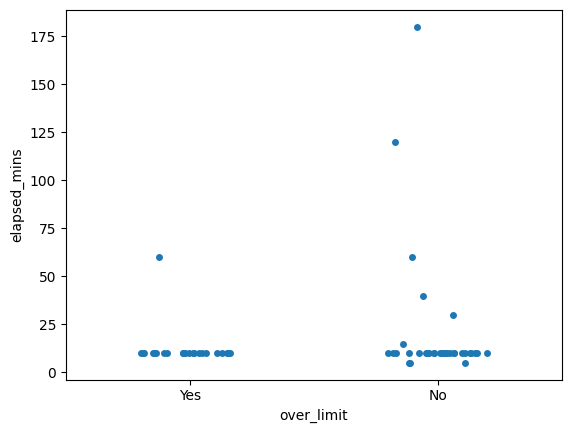

In [18]:
plot = stripplot(x="over_limit", y="elapsed_mins", data=copy_df, jitter=0.2)
# This one only works properly if you've done some preprocessing earlier!

<p>
    It's your job to think about feature engineering. 
</p>

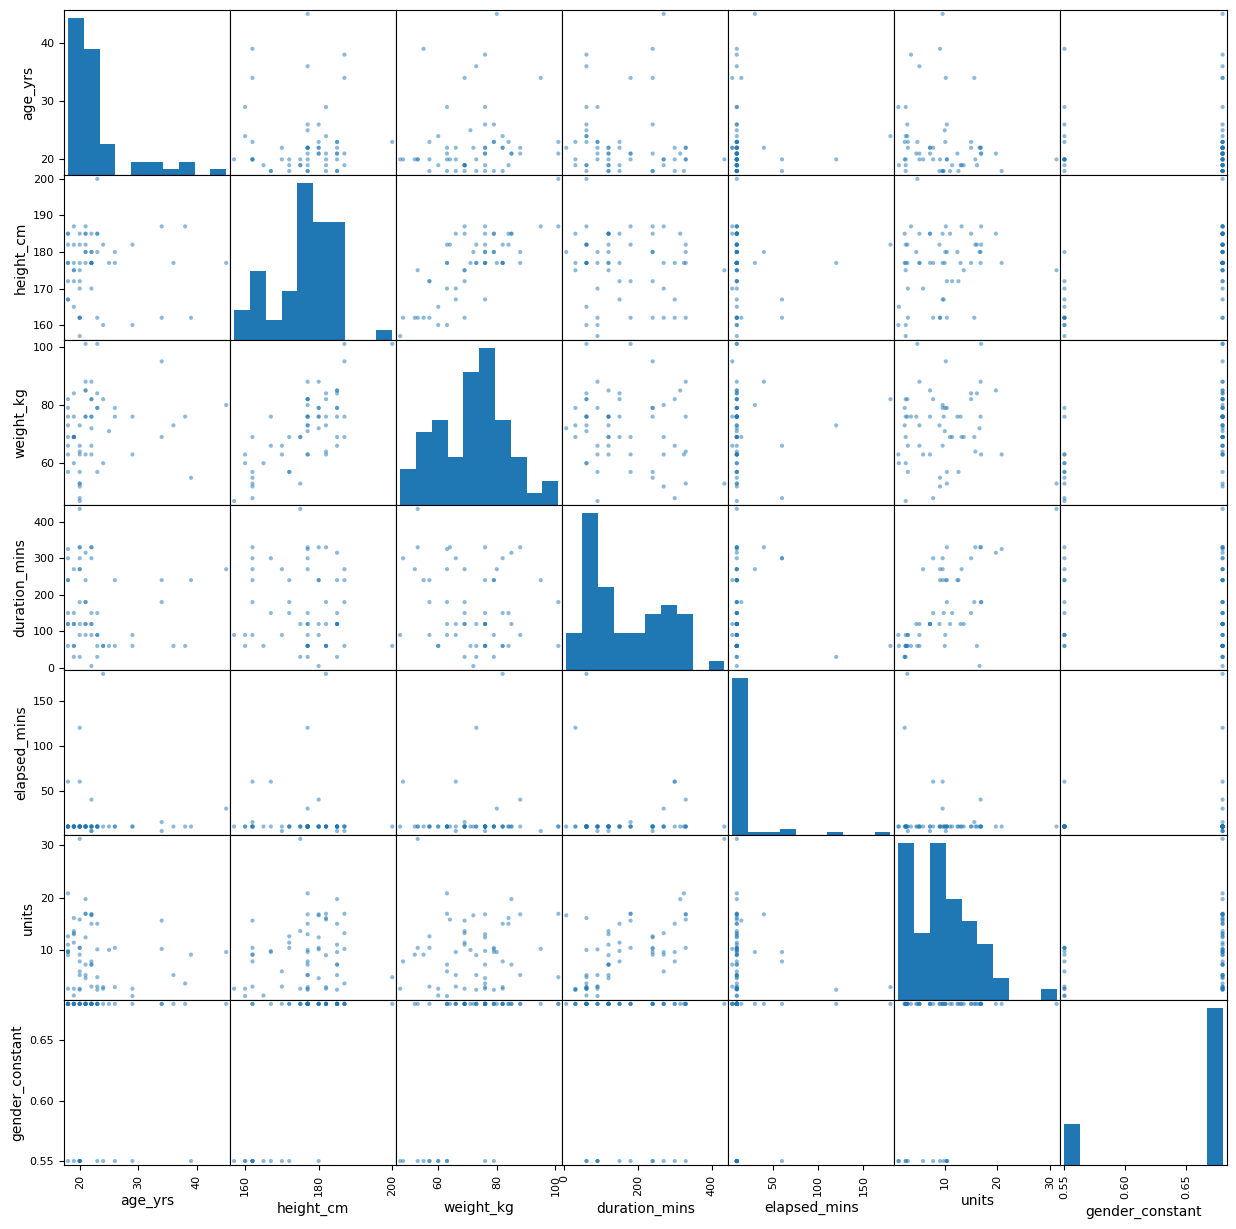

In [19]:
m = scatter_matrix(copy_df, figsize=(15, 15))

/tmp/ipykernel_26018/1123110122.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap(copy_df.corr(), annot=True)


<AxesSubplot: >

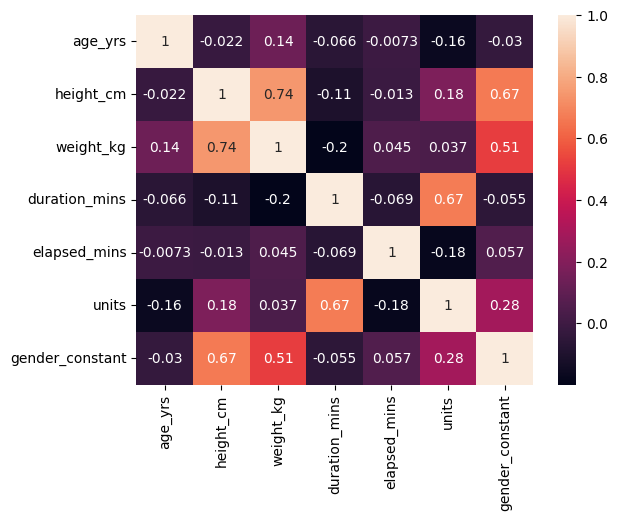

In [20]:
heatmap(copy_df.corr(), annot=True)

In [21]:
copy_df["uwr"] = copy_df["units"] / (copy_df["weight_kg"] * copy_df["gender_constant"])

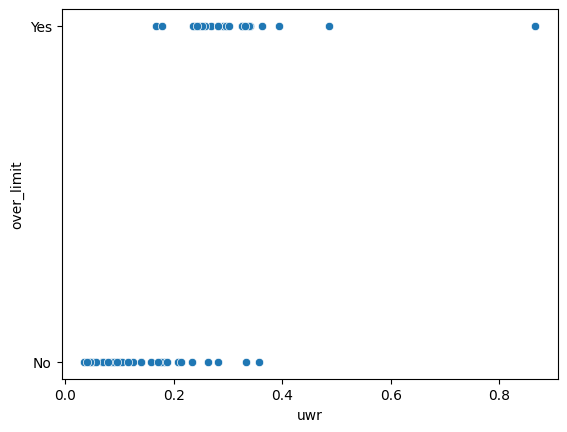

In [22]:
plot = scatterplot(x="uwr", y="over_limit", data=copy_df)

In [23]:
copy_df["units_elapsed"] = copy_df["units"] - 0.015 * df["elapsed_mins"]
for value in copy_df["units_elapsed"]:
    if value < 0:
        copy_df["units_elapsed"] = copy_df["units_elapsed"].replace([value], 0)

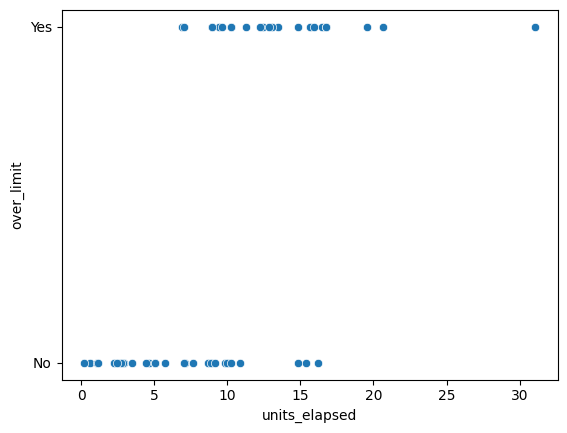

In [24]:
plot = scatterplot(x="units_elapsed", y="over_limit", data=copy_df)

In [25]:
copy_df["drinking_speed"] = copy_df["units"] / df["duration_mins"]

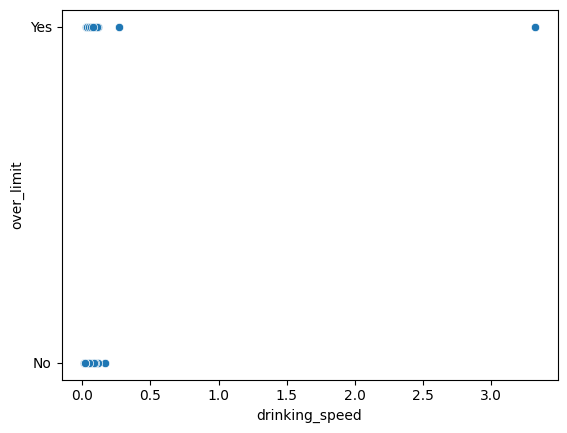

In [26]:
plot = scatterplot(x="drinking_speed", y="over_limit", data=copy_df)

In [27]:
class InsertUWR(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["uwr"] = X["units"] / (X["weight_kg"] * X["gender_constant"])
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
#             X.drop(["cement", "water"], axis=1)
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [28]:
preprocessor = ColumnTransformer([
        ("num", Pipeline([("uwr", InsertUWR()),
                        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                        ("scaler", StandardScaler())]), numeric_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                        ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), nominal_features)],
        remainder="passthrough")

<h1>Model Selection</h1>

<p>
    It's your job to create any classes to insert new features.
</p>
<p>
    Then, write a preprocessor. You'll need to scale the numeric features. 
    And you'll need a one-hot encoder for the non-numeric features.
</p>
<p>
    Then try out logistic regression and kNN. Remember to user "accuracy" as the evaluation function.
</p>

In [29]:
logreg = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LogisticRegression())])

logreg_param_grid = {
    "preprocessor__num__uwr__insert": [True, False]
}

logreg_gs = GridSearchCV(logreg, logreg_param_grid, scoring="accuracy", cv=10, refit=True)

logreg_gs.fit(dev_X, dev_y)

logreg_gs.best_params_, logreg_gs.best_score_

({'preprocessor__num__uwr__insert': True}, 0.7733333333333332)

In [30]:
logreg = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsClassifier())])

logreg_param_grid = {
    "predictor__n_neighbors": [x for x in range(1, 11)],
    "preprocessor__num__uwr__insert": [True, False]
}

logreg_gs = GridSearchCV(logreg, logreg_param_grid, scoring="accuracy", cv=10, refit=True)

logreg_gs.fit(dev_X, dev_y)

logreg_gs.best_params_, logreg_gs.best_score_

({'predictor__n_neighbors': 3, 'preprocessor__num__uwr__insert': True},
 0.8066666666666666)

<h1>Evaluate on the Test Set</h1>
<p>
    Once you've finished tweaking and tuning, then do error estimation (in fact, accuracy estimation)
    on the test set. Use accuracy_score from sklearn.metrics as the evaluation function.
</p>